In [1]:
from google.colab import drive 
drive.mount("/content/drive", force_remount=True)
# Change directory to the package folder 
%cd '/content/drive/MyDrive/dl-project'


Mounted at /content/drive
/content/drive/MyDrive/dl-project


In [2]:
# pip install --upgrade pip

In [3]:
# import os
# import yaml

# with open("environment.yml") as file_handle:
#     environment_data = yaml.safe_load(file_handle)

# for dependency in environment_data["dependencies"]:
#     if isinstance(dependency, dict):
#       for lib in dependency['pip']:
#         os.system(f"pip install {lib}")

In [4]:
!pip install transformers datasets matplotlib
!apt install libomp-dev
!python -m pip install --upgrade faiss-gpu==1.7.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libomp-dev is already the newest version (1:10.0-50~exp1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# ! pip install -q kaggle

In [6]:
# os.environ['TOKENIZERS_PARALLELISM'] = 'true' # or 'false'

In [7]:
# !mv ./kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [8]:
# Must sign up for the competition and verify your account with a text message before downloading the data

In [9]:
# ! kaggle competitions download -c 'shopee-product-matching'

In [10]:
# !unzip -q -o ./shopee-product-matching.zip -d ./shopee-product-matching/

In [11]:
import numpy as np
import pandas as pd
import matplotlib

import torch
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
from transformers import AutoTokenizer
from tqdm import tqdm
from modules.datasets.ImageShopeeDataset import ImageShopeeDataset
from modules.datasets.TextShopeeDataset import TextShopeeDataset
from modules.models.ResNet18EmbeddingsShopeeNet import ResNet18EmbeddingsShopeeNet
from modules.models.BERTPreTrainedEmbeddingsShopeeNet import BERTPreTrainedEmbeddingsShopeeNet
from modules.utils.CommonVIsualizer import CommonVisualizer
from modules.utils.F1ScoreEvaluator import F1ScoreEvaluator
from modules.utils.EmbeddingsProducer import EmbeddingsProducer
import faiss
import os

In [12]:
DATA_FOLDER = './shopee-product-matching/'

IS_TEST = False

def get_dataset(root=DATA_FOLDER, is_test=False):
    name = "test.csv" if is_test else "train.csv"
    df = pd.read_csv(DATA_FOLDER + name)
    images_folder = "test_images/" if is_test else "train_images/"
    df['image'] = DATA_FOLDER + images_folder + df['image']
    return df

def add_target(df):
    grouped = df.groupby('label_group')['posting_id'].apply(list)
    target = df['label_group'].map(grouped)
    new_df = df.copy()
    new_df['target'] = target
    return new_df

df = get_dataset(is_test=IS_TEST)
train = add_target(df)

In [13]:
# Prepare DataLoaders
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
text_dataset = TextShopeeDataset(train['title'].values)

def my_collate_fn(data):
    """
    data: list of input text strings
    return: dict with keys: input_ids, token_type_ids, attention_mask where each key is a tensor
    """
    
    # This probably could be optimized if we don't want to instantiate a new tokenizer each iteration.
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased") 
    inputs = tokenizer(data, padding=True, return_tensors="pt")
    return inputs
    
text_loader = torch.utils.data.DataLoader(
    text_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    collate_fn=my_collate_fn
)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [14]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_pretrain_model = BERTPreTrainedEmbeddingsShopeeNet()
bert_pretrain_model.to(DEVICE)

producer = EmbeddingsProducer(bert_pretrain_model, DEVICE)
text_embeddings = producer.get_embeddings(text_loader, normalize=True)
print(text_embeddings.shape)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 268/268 [02:04<00:00,  2.15it/s]


(34250, 768)


In [15]:
# please ensure that text_embeddings and train dataframe have the same order and embeddings correspond to postings
f1_score_eval = F1ScoreEvaluator(train, text_embeddings, k=100)
thresholds = np.arange(0.83, 0.99, 0.01)
f1_avg_scores = f1_score_eval.get_avg_f1_scores_for_thresholds(thresholds)

100%|██████████| 17/17 [04:14<00:00, 14.95s/it]


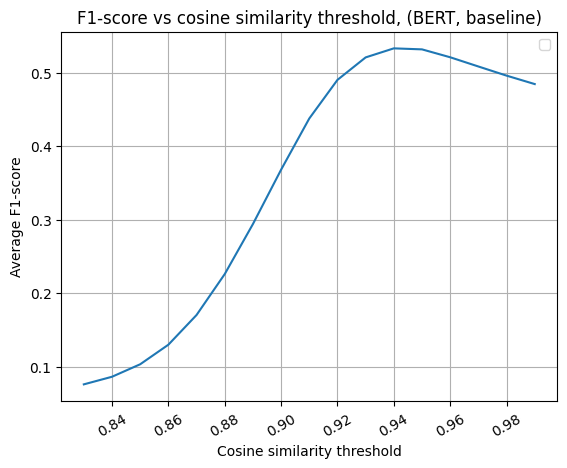

In [16]:

visualizer = CommonVisualizer()
visualizer.plt_f1_score_vs_threshold(thresholds, f1_avg_scores, 'BERT, baseline', 'bert-baseline-thresholds.png')
max_f1 = max(f1_avg_scores)
max_threshold = thresholds[np.argmax(f1_avg_scores)]
# plt.savefig('cnn-baseline-thresholds.png')

In [17]:
print(f"Max f1-score: {max_f1}, threshold: {max_threshold}") 

Max f1-score: 0.532954304069146, threshold: 0.9400000000000001
